In [1]:
#IMPORT STANDARD LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#IMPORT MACHINE LEARNING LIBRARIES
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


from sklearn.tree import export_graphviz

In [3]:
#LOAD FMA-ROCK-VS-HIPHIP.CSV
tracks = pd.read_csv('../input/audio-data/fma-rock-vs-hiphop.csv')
print (tracks)

       track_id  bit_rate  comments        composer         date_created  \
0           135    256000         1             NaN  2008-11-26 01:43:26   
1           136    256000         1             NaN  2008-11-26 01:43:35   
2           151    192000         0             NaN  2008-11-26 01:44:55   
3           152    192000         0             NaN  2008-11-26 01:44:58   
4           153    256000         0  Arc and Sender  2008-11-26 01:45:00   
...         ...       ...       ...             ...                  ...   
17729    155063    320000         0             NaN  2017-03-24 19:40:43   
17730    155064    320000         0             NaN  2017-03-24 19:40:44   
17731    155065    320000         0             NaN  2017-03-24 19:40:45   
17732    155066    320000         0             NaN  2017-03-24 19:40:47   
17733    155247    320000         0         Fleslit  2017-03-29 01:40:28   

             date_recorded  duration  favorites genre_top          genres  \
0      200

In [4]:
#LOAD ECHONEST-METRICS.JSON
echonest_metrics = pd.read_json('../input/audio-data/echonest-metrics.json',precise_float=True)
print(echonest_metrics)

       track_id  acousticness  danceability    energy  instrumentalness  \
0             2      0.416675      0.675894  0.634476          0.010628   
1             3      0.374408      0.528643  0.817461          0.001851   
2             5      0.043567      0.745566  0.701470          0.000697   
3            10      0.951670      0.658179  0.924525          0.965427   
4           134      0.452217      0.513238  0.560410          0.019443   
...         ...           ...           ...       ...               ...   
13124    124857      0.007592      0.790364  0.719288          0.853114   
13125    124862      0.041498      0.843077  0.536496          0.865151   
13126    124863      0.000124      0.609686  0.895136          0.846624   
13127    124864      0.327576      0.574426  0.548327          0.452867   
13128    124911      0.993606      0.499339  0.050622          0.945677   

       liveness  speechiness    tempo   valence  
0      0.177647     0.159310  165.922  0.576661  

In [5]:
#MERGE ECHONEST_METRICS & TRACKS ON TRACK ID
echo_tracks = echonest_metrics.merge(tracks[['track_id','genre_top']],on='track_id',how='inner')
print(echo_tracks)

      track_id  acousticness  danceability    energy  instrumentalness  \
0            2      0.416675      0.675894  0.634476      1.062807e-02   
1            3      0.374408      0.528643  0.817461      1.851103e-03   
2            5      0.043567      0.745566  0.701470      6.967990e-04   
3          134      0.452217      0.513238  0.560410      1.944269e-02   
4          153      0.988306      0.255661  0.979774      9.730057e-01   
...        ...           ...           ...       ...               ...   
4797    124718      0.412194      0.686825  0.849309      6.000000e-10   
4798    124719      0.054973      0.617535  0.728567      7.215700e-06   
4799    124720      0.010478      0.652483  0.657498      7.098000e-07   
4800    124721      0.067906      0.432421  0.764508      1.625500e-06   
4801    124722      0.153518      0.638660  0.762567      5.000000e-10   

      liveness  speechiness    tempo   valence genre_top  
0     0.177647     0.159310  165.922  0.576661   Hip

In [6]:
print(echo_tracks.info())
print("\n\n",echo_tracks.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4802 entries, 0 to 4801
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          4802 non-null   int64  
 1   acousticness      4802 non-null   float64
 2   danceability      4802 non-null   float64
 3   energy            4802 non-null   float64
 4   instrumentalness  4802 non-null   float64
 5   liveness          4802 non-null   float64
 6   speechiness       4802 non-null   float64
 7   tempo             4802 non-null   float64
 8   valence           4802 non-null   float64
 9   genre_top         4802 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 412.7+ KB
None


             track_id  acousticness  danceability       energy  \
count    4802.000000  4.802000e+03   4802.000000  4802.000000   
mean    30164.871720  4.870600e-01      0.436556     0.625126   
std     28592.013796  3.681396e-01      0.183502     0.244051 

In [7]:
print(echo_tracks.isna().sum())

track_id            0
acousticness        0
danceability        0
energy              0
instrumentalness    0
liveness            0
speechiness         0
tempo               0
valence             0
genre_top           0
dtype: int64


In [8]:
print(echo_tracks['genre_top'].value_counts())

Rock       3892
Hip-Hop     910
Name: genre_top, dtype: int64


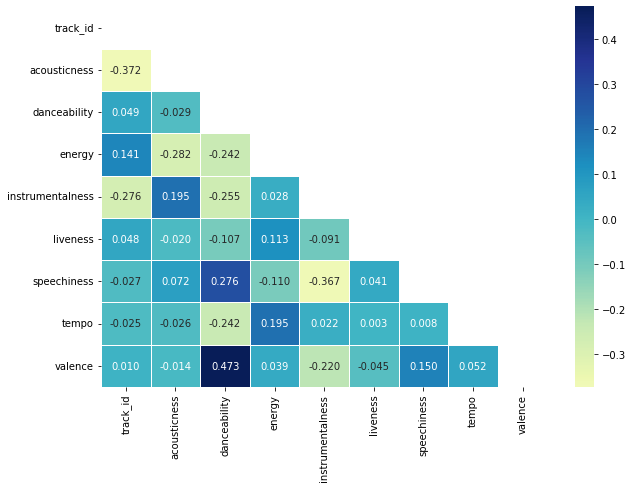

In [9]:
fig, ax = plt.subplots(figsize=(10, 7))
mask = np.zeros_like(echo_tracks.corr())
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(echo_tracks.corr(),annot=True, fmt='0.3f',center=0,linewidths=1,cmap="YlGnBu", mask=mask)
plt.show()

In [10]:
#DEFINE FEATURES AND LABEL
X = echo_tracks.drop(['genre_top'], axis =1)
y = echo_tracks['genre_top']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(3841, 9)
(961, 9)
(3841,)
(961,)


In [11]:
pca = PCA()

sc = StandardScaler()

dtc = DecisionTreeClassifier(random_state=123)

steps = [('SC',sc), ('PCA', pca), ('DTC', dtc)]

model = Pipeline(steps)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("\nDecision Tree Classifier\n")
print(model,"\n")
print("Counfusion Matrix: \n",confusion_matrix (y_test, y_pred),"\n")
print("Classification Report: \n", classification_report (y_test, y_pred), "\n")
print("Accuracy Score:  %0.3f \n" %accuracy_score(y_test,y_pred), "\n")


Decision Tree Classifier

Pipeline(steps=[('SC', StandardScaler()), ('PCA', PCA()),
                ('DTC', DecisionTreeClassifier(random_state=123))]) 

Counfusion Matrix: 
 [[111  79]
 [ 57 714]] 

Classification Report: 
               precision    recall  f1-score   support

     Hip-Hop       0.66      0.58      0.62       190
        Rock       0.90      0.93      0.91       771

    accuracy                           0.86       961
   macro avg       0.78      0.76      0.77       961
weighted avg       0.85      0.86      0.86       961
 

Accuracy Score:  0.858 
 



In [12]:
pca = PCA()

sc = StandardScaler()

logreg = LogisticRegression(random_state=123)

steps = [('SC',sc), ('PCA', pca), ('LOGREG', logreg)]

model = Pipeline(steps)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("\nLogistic Regression\n")
print(model,"\n")
print("Counfusion Matrix: \n",confusion_matrix (y_test, y_pred),"\n")
print("Classification Report: \n", classification_report (y_test, y_pred), "\n")
print("Accuracy Score:  %0.3f \n" %accuracy_score(y_test,y_pred), "\n")


Logistic Regression

Pipeline(steps=[('SC', StandardScaler()), ('PCA', PCA()),
                ('LOGREG', LogisticRegression(random_state=123))]) 

Counfusion Matrix: 
 [[107  83]
 [ 20 751]] 

Classification Report: 
               precision    recall  f1-score   support

     Hip-Hop       0.84      0.56      0.68       190
        Rock       0.90      0.97      0.94       771

    accuracy                           0.89       961
   macro avg       0.87      0.77      0.81       961
weighted avg       0.89      0.89      0.88       961
 

Accuracy Score:  0.893 
 



In [13]:
pca = PCA()

sc = StandardScaler()

gnb = GaussianNB()

steps = [('SC',sc), ('PCA', pca), ('GNB', gnb)]

model = Pipeline(steps)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("\nGaussian Naive Bayes\n")
print(model,"\n")
print("Counfusion Matrix: \n",confusion_matrix (y_test, y_pred),"\n")
print("Classification Report: \n", classification_report (y_test, y_pred), "\n")
print("Accuracy Score:  %0.3f \n" %accuracy_score(y_test,y_pred), "\n")


Gaussian Naive Bayes

Pipeline(steps=[('SC', StandardScaler()), ('PCA', PCA()),
                ('GNB', GaussianNB())]) 

Counfusion Matrix: 
 [[110  80]
 [ 26 745]] 

Classification Report: 
               precision    recall  f1-score   support

     Hip-Hop       0.81      0.58      0.67       190
        Rock       0.90      0.97      0.93       771

    accuracy                           0.89       961
   macro avg       0.86      0.77      0.80       961
weighted avg       0.88      0.89      0.88       961
 

Accuracy Score:  0.890 
 



In [14]:
pca = PCA()

sc = StandardScaler()

svc= SVC(random_state=123)

steps = [('SC',sc), ('PCA', pca), ('SVC', svc)]

model = Pipeline(steps)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("\nSupport Vector Machine\n")
print(model,"\n")
print("Counfusion Matrix: \n",confusion_matrix (y_test, y_pred),"\n")
print("Classification Report: \n", classification_report (y_test, y_pred), "\n")
print("Accuracy Score:  %0.3f \n" %accuracy_score(y_test,y_pred), "\n")


Support Vector Machine

Pipeline(steps=[('SC', StandardScaler()), ('PCA', PCA()),
                ('SVC', SVC(random_state=123))]) 

Counfusion Matrix: 
 [[131  59]
 [ 12 759]] 

Classification Report: 
               precision    recall  f1-score   support

     Hip-Hop       0.92      0.69      0.79       190
        Rock       0.93      0.98      0.96       771

    accuracy                           0.93       961
   macro avg       0.92      0.84      0.87       961
weighted avg       0.93      0.93      0.92       961
 

Accuracy Score:  0.926 
 



In [15]:
pca = PCA()

sc = StandardScaler()

rand= RandomForestClassifier(random_state=123)

steps = [('SC',sc), ('PCA', pca), ('RAND', rand)]

model = Pipeline(steps)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("\nRandom Forest Classifier\n")
print(model,"\n")
print("Counfusion Matrix: \n",confusion_matrix (y_test, y_pred),"\n")
print("Classification Report: \n", classification_report (y_test, y_pred), "\n")
print("Accuracy Score:  %0.3f \n" %accuracy_score(y_test,y_pred), "\n")


Random Forest Classifier

Pipeline(steps=[('SC', StandardScaler()), ('PCA', PCA()),
                ('RAND', RandomForestClassifier(random_state=123))]) 

Counfusion Matrix: 
 [[124  66]
 [ 18 753]] 

Classification Report: 
               precision    recall  f1-score   support

     Hip-Hop       0.87      0.65      0.75       190
        Rock       0.92      0.98      0.95       771

    accuracy                           0.91       961
   macro avg       0.90      0.81      0.85       961
weighted avg       0.91      0.91      0.91       961
 

Accuracy Score:  0.913 
 



In [16]:
kf = KFold(10)

pca = PCA()

sc = StandardScaler()

steps = [('SC',sc), ('PCA', pca)]

model = Pipeline(steps)


tree_score = cross_val_score(dtc, X_train, y_train, cv=kf)
logreg_score = cross_val_score(logreg, X_train, y_train, cv=kf)
GNB_score = cross_val_score(gnb, X_train, y_train, cv=kf)
SVC_score = cross_val_score(svc, X_train, y_train, cv=kf)
RAND_score = cross_val_score(rand, X_train, y_train, cv=kf)


print("Decision Tree Score: %0.3f" %tree_score.mean())
print("Logistic Regression Score: %0.3f" %logreg_score.mean())
print("Gaussian Naive Bayes Score: %0.3f" %GNB_score.mean())
print("Support Vector Machine Score: %0.3f" %SVC_score.mean())
print("Random Forest Score: %0.3f" %RAND_score.mean())


Decision Tree Score: 0.898
Logistic Regression Score: 0.824
Gaussian Naive Bayes Score: 0.813
Support Vector Machine Score: 0.813
Random Forest Score: 0.933
